In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, roc_curve, recall_score
from tensorflow import keras
from tensorflow.keras.utils import plot_model
import datetime
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import StratifiedKFold
import seaborn as sn

# Parameter

In [ ]:
INIT_LR = 1e-3
EPOCHS = 150
BS = 32
seed = 42

In [ ]:
image_size = (224, 224)

# Prepare_Data

In [ ]:
imagePaths_label_0 = '/content/drive/MyDrive/Colab Notebooks/聖馬爾定/Dataset/Original_224X224/0'
imagePaths_label_1 = '/content/drive/MyDrive/Colab Notebooks/聖馬爾定/Dataset/Original_224X224/1'

filenames_0 = os.listdir(imagePaths_label_0)
filenames_1 = os.listdir(imagePaths_label_1)

In [ ]:
print(len(filenames_0))
print(len(filenames_1))

107
58


In [ ]:
label_0 = pd.DataFrame({'picture_name': filenames_0})
label_0['label'] = '0'
label_0['path'] = '0/' + label_0['picture_name']

In [ ]:
label_1 = pd.DataFrame({'picture_name': filenames_1})
label_1['label'] = '1'
label_1['path'] = '1/' + label_1['picture_name']

In [ ]:
alldata = pd.concat([label_0, label_1])

In [ ]:
alldata.shape

(165, 3)

In [ ]:
train_df, test_df = train_test_split(alldata, test_size=0.15, random_state=seed)

In [ ]:
total_train = train_df.shape[0]

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=15, 
                                   rescale=1./255, 
                                   shear_range=0.1, 
                                   zoom_range=0.2,
                                   brightness_range = [1.4, 1.4],
                                   horizontal_flip=True, 
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   validation_split=0.15)

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    '/content/drive/MyDrive/Colab Notebooks/聖馬爾定/Dataset/Original_224X224/', 
                                                    x_col='path', 
                                                    y_col='label', 
                                                    target_size=image_size, 
                                                    class_mode='categorical', 
                                                    batch_size=BS, 
                                                    subset='training')


Found 119 validated image filenames belonging to 2 classes.


In [ ]:
validation_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    '/content/drive/MyDrive/Colab Notebooks/聖馬爾定/Dataset/Original_224X224/', 
                                                    x_col='path', 
                                                    y_col='label', 
                                                    target_size=image_size, 
                                                    class_mode='categorical', 
                                                    batch_size=BS,
                                                    subset='validation')

Found 21 validated image filenames belonging to 2 classes.


In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    '/content/drive/MyDrive/Colab Notebooks/聖馬爾定/Dataset/Original_224X224/', 
    x_col='path', 
    y_col=None, 
    class_mode=None, 
    target_size=image_size, 
    batch_size=1,
    shuffle=False
)

Found 25 validated image filenames.


# Model_InceptionResNetV2

In [ ]:
baseModel = InceptionResNetV2(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(image_size[0], image_size[1], 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax", name="predictions")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=7, 
                                            factor=0.5, 
                                            min_lr=0.00001)

mcp_save = ModelCheckpoint('InceptionResNetV2_wts.h5', save_best_only=True, monitor='val_accuracy', mode='max')

callbacks = [learning_rate_reduction, mcp_save]

In [ ]:
H = model.fit(
		train_generator,
    # steps_per_epoch=train_generator.samples // BS,
    epochs=EPOCHS,
    validation_data= validation_generator,
    # validation_steps=validation_generator.samples // BS,
    callbacks=callbacks)

Epoch 1/150
4/4 [==============================] - 7s 2s/step - loss: 0.9856 - accuracy: 0.6134 - val_loss: 0.6976 - val_accuracy: 0.6190
Epoch 2/150
4/4 [==============================] - 3s 858ms/step - loss: 0.8546 - accuracy: 0.5462 - val_loss: 0.5465 - val_accuracy: 0.7619
Epoch 3/150
4/4 [==============================] - 2s 447ms/step - loss: 0.6418 - accuracy: 0.6471 - val_loss: 0.5754 - val_accuracy: 0.5238
Epoch 4/150
4/4 [==============================] - 3s 806ms/step - loss: 0.5700 - accuracy: 0.7479 - val_loss: 0.5174 - val_accuracy: 0.8571
Epoch 5/150
4/4 [==============================] - 2s 444ms/step - loss: 0.4870 - accuracy: 0.7479 - val_loss: 0.5426 - val_accuracy: 0.7143
Epoch 6/150
4/4 [==============================] - 2s 499ms/step - loss: 0.5318 - accuracy: 0.7647 - val_loss: 0.4875 - val_accuracy: 0.7619
Epoch 7/150
4/4 [==============================] - 2s 456ms/step - loss: 0.4649 - accuracy: 0.7563 - val_loss: 0.5000 - val_accuracy: 0.7619
Epoch 8/150
4/4 

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/聖馬爾定/Model/IncepRes_model_Original_224X224.h5')
model.save_weights('/content/drive/My Drive/Colab Notebooks/聖馬爾定/Model/IncepRes_weight_Original_224X224.h5')

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/聖馬爾定/Model/Weights/IncepRes_model_Original.h5')

In [ ]:
#model.summary()

# Plot_History of Accuracy, Loss

Text(0, 0.5, 'Accuracy')

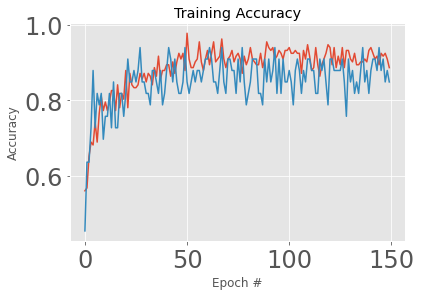

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
#plt.ylim(0, 1)
# plt.legend(loc="best")

Text(0, 0.5, 'Loss')

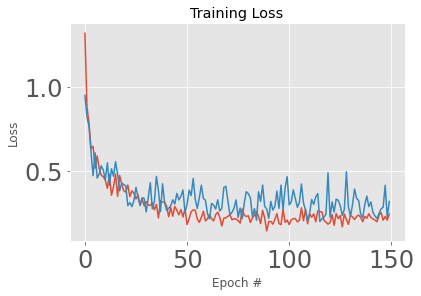

In [ ]:
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")

# Model_Predict

Train_Predict

In [ ]:
train_gen = ImageDataGenerator(rescale=1./255)

train_generator_test = train_gen.flow_from_dataframe(
    train_df, 
    '/content/drive/MyDrive/Colab Notebooks/聖馬爾定/Dataset/Original_224X224/', 
    x_col='path', 
    y_col=None, 
    class_mode=None, 
    target_size=image_size, 
    batch_size=1,
    shuffle=False
)

Found 140 validated image filenames.


In [ ]:
predict = model.predict(train_generator_test)

In [ ]:
train_predict = np.argmax(predict, axis=-1).astype('str')

In [ ]:
train_df['predict'] = train_predict

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train_df[train_df['label'] != train_df['predict']]

,picture_name,label,path,predict
2,0009911_0804032249_I00060161231_1.jpg,0,0/0009911_0804032249_I00060161231_1.jpg,1
39,4595198_0512120848_I00042975881_1.jpg,1,1/4595198_0512120848_I00042975881_1.jpg,0
77,0945091_0707210724_I00054748312_1.jpg,0,0/0945091_0707210724_I00054748312_1.jpg,1
3,7256531_0709271027_I00056184218_1.jpg,1,1/7256531_0709271027_I00056184218_1.jpg,0
8,0009911_0804032249_I00060161232_1.jpg,0,0/0009911_0804032249_I00060161232_1.jpg,1
6,0591728_0609211214_I00048777599_1.jpg,1,1/0591728_0609211214_I00048777599_1.jpg,0
33,0208952_0602130355_I00044189823_1.jpg,1,1/0208952_0602130355_I00044189823_1.jpg,0
99,8702765_0703121563_I00051982783_1.jpg,0,0/8702765_0703121563_I00051982783_1.jpg,1


Test_Predict

In [ ]:
predict = model.predict(test_generator)

In [ ]:
test_predict = np.argmax(predict, axis=-1).astype('str')

In [ ]:
test_df['predict'] = test_predict

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_df[test_df['label'] != test_df['predict']]

,picture_name,label,path,predict


In [ ]:
concate = pd.concat([train_df, test_df], axis=0, ignore_index=False)
concate = concate.sort_values(by=['picture_name'])
concate.to_csv('Org.csv', index=0)

# Performance

Train

In [ ]:
y_test = train_df['label'].astype('int32').values
pre_y = train_df['predict'].astype('int32').values

confusion_train = confusion_matrix(y_test, pre_y)
df_confusion_test = pd.DataFrame(confusion_train, columns=['Negative', 'Positive'], index=['Negative', 'Positive'])
df_confusion_test.index.name = 'Real'
df_confusion_test.columns.name = 'Predict'

df_confusion_test

Predict,Negative,Positive
Real,,
Negative,85,4
Positive,4,47


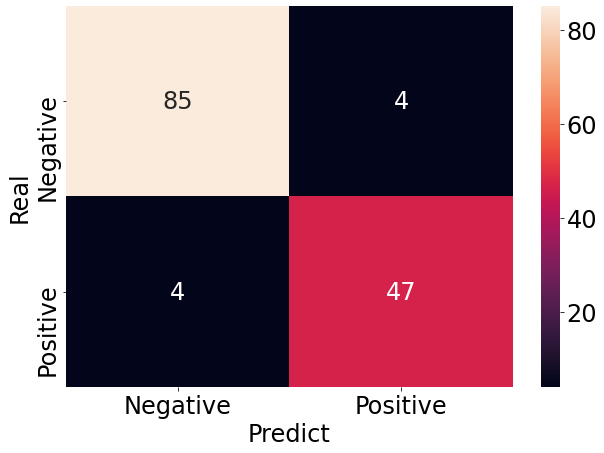

In [ ]:
y_test = train_df['label'].astype('int32').values
pre_y = train_df['predict'].astype('int32').values

confusion_train = confusion_matrix(y_test, pre_y)
df_confusion_test = pd.DataFrame(confusion_train, columns=['Negative', 'Positive'], index=['Negative', 'Positive'])
df_confusion_test.index.name = 'Real'
df_confusion_test.columns.name = 'Predict'

SMALL_SIZE = 24
MEDIUM_SIZE = 24
BIGGER_SIZE = 12

plt.figure(figsize = (10,7))
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)
sn.heatmap(df_confusion_test, annot=True)

             auc  accuracy  precision    recall        f1
result  0.938312  0.942857   0.921569  0.921569  0.921569


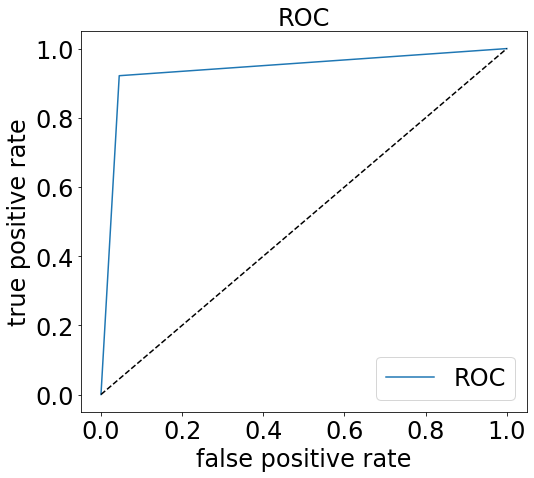

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, pre_y)

AUC = auc(fpr, tpr)

#Accuracy
accuracy = accuracy_score(y_test, pre_y)

precision = precision_score(y_test, pre_y)

recall = recall_score(y_test, pre_y)

f1 = f1_score(y_test, pre_y)

df_metrics_train = pd.DataFrame([[AUC, accuracy, precision, recall, f1]], columns=['auc', 'accuracy', 'precision', 'recall', 'f1'], index=['result'])
print(df_metrics_train)

plt.figure(figsize=(8, 7))
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], linestyle='--', color='k')

plt.title('ROC')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc=0)

Test

In [ ]:
y_test = test_df['label'].astype('int32').values
pre_y = test_df['predict'].astype('int32').values

In [ ]:
confusion_test = confusion_matrix(y_test, pre_y)

In [ ]:
confusion_test

array([[18,  0],
       [ 0,  7]])

In [ ]:
df_confusion_test = pd.DataFrame(confusion_test, columns=['Negative', 'Positive'], index=['Negative', 'Positive'])

In [ ]:
df_confusion_test.index.name = 'Real'
df_confusion_test.columns.name = 'Predict'
df_confusion_test

Predict,Negative,Positive
Real,,
Negative,18,0
Positive,0,7


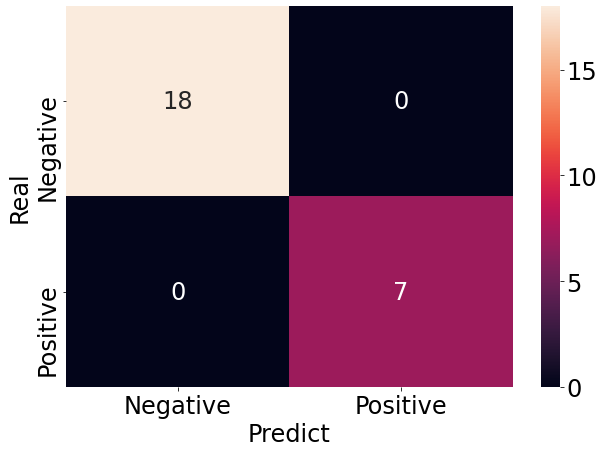

In [ ]:
plt.figure(figsize = (10,7))
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)
sn.heatmap(df_confusion_test, annot=True)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, pre_y)

AUC = auc(fpr, tpr)

#Accuracy
accuracy = accuracy_score(y_test, pre_y)

precision = precision_score(y_test, pre_y)

recall = recall_score(y_test, pre_y)

f1 = f1_score(y_test, pre_y)

df_metrics_test = pd.DataFrame([[AUC, accuracy, precision, recall, f1]], columns=['auc', 'accuracy', 'precision', 'recall', 'f1'], index=['result'])
df_metrics_test

,auc,accuracy,precision,recall,f1
result,1.0,1.0,1.0,1.0,1.0


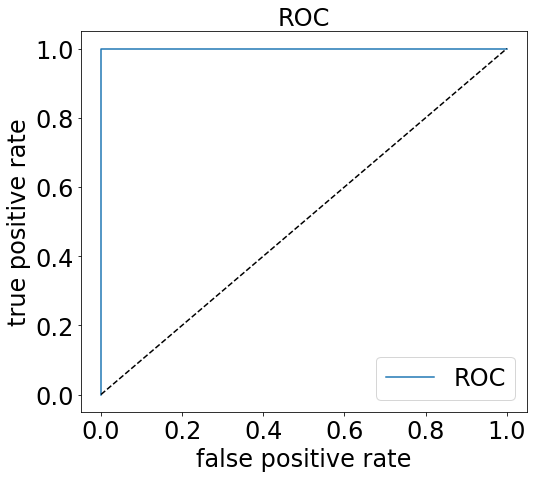

In [ ]:
plt.figure(figsize=(8, 7))
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], linestyle='--', color='k')

plt.title('ROC')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc=0)

# Cross Validation

In [ ]:
def create_new_model():
  baseModel = InceptionResNetV2(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(image_size[0], image_size[1], 3)))
  
  headModel = baseModel.output
  headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
  headModel = Flatten(name="flatten")(headModel)
  headModel = Dense(64, activation="relu")(headModel)
  headModel = Dropout(0.5)(headModel)
  headModel = Dense(2, activation="softmax", name="predictions")(headModel)
  
  model = Model(inputs=baseModel.input, outputs=headModel)
  
  for layer in baseModel.layers:
    layer.trainable = False
  
  opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
  model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

  return model

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
Y = alldata[['label']]

train_cv_datagen = ImageDataGenerator(rotation_range=15, 
                                   rescale=1./255, 
                                   shear_range=0.1, 
                                   zoom_range=0.2,
                                   brightness_range = [1.4, 1.4],
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

In [ ]:
accuracy = []
precision = []
recall = []
f1 = []

k_fold = 1

for train_index, test_index in kf.split(np.zeros(len(alldata)),Y):
  training_data = alldata.iloc[train_index]
  test_data = alldata.iloc[test_index]

  train_generator = train_cv_datagen.flow_from_dataframe(training_data, 
                                                    '/content/drive/MyDrive/Colab Notebooks/聖馬爾定/Dataset/Original_224X224/', 
                                                    x_col='path', 
                                                    y_col='label', 
                                                    target_size=image_size, 
                                                    class_mode='categorical', 
                                                    batch_size=BS,
                                                    seed=40)
  
  validation_generator = train_cv_datagen.flow_from_dataframe(test_data, 
                                                    '/content/drive/MyDrive/Colab Notebooks/聖馬爾定/Dataset/Original_224X224/', 
                                                    x_col='path', 
                                                    y_col='label', 
                                                    target_size=image_size, 
                                                    class_mode='categorical', 
                                                    batch_size=BS,
                                                    seed=40)
  
  model = create_new_model()

  learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=7, 
                                            factor=0.5, 
                                            min_lr=0.00001)
  callbacks = [learning_rate_reduction]
  
  H = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data= validation_generator,
      callbacks=callbacks
      )
  
  model.save('/content/drive/My Drive/Colab Notebooks/聖馬爾定/Model/Weights/Cross_Validation/original_224X224/IncepRes_model_'+ str(k_fold) +'_Original.h5')

  results = model.evaluate(validation_generator)
  results = dict(zip(model.metrics_names,results))
  accuracy.append(results['accuracy'])

  tf.keras.backend.clear_session()

  k_fold += 1

In [ ]:
performance = pd.DataFrame(accuracy, columns=['Accuracy'])
# performance['Precision'] = precision
# performance['Recall'] = recall
# performance['F1'] = f1

performance

,Accuracy
0,0.818182
1,0.878788
2,0.848485
3,0.696970
4,0.939394


In [ ]:
performance.describe()

,Accuracy
count,5.000000
mean,0.836364
std,0.089893
min,0.696970
25%,0.818182
50%,0.848485
75%,0.878788
max,0.939394


# Class_Grad_Cam

In [ ]:
class GradCAM:
	def __init__(self, model, classIdx, layerName=None):
		# store the model, the class index used to measure the class
		# activation map, and the layer to be used when visualizing
		# the class activation map
		self.model = model
		self.classIdx = classIdx
		self.layerName = layerName

		# if the layer name is None, attempt to automatically find
		# the target output layer
		if self.layerName is None:
			self.layerName = self.find_target_layer()

	def find_target_layer(self):
		# attempt to find the final convolutional layer in the network
		# by looping over the layers of the network in reverse order
		for layer in reversed(self.model.layers):
			# check to see if the layer has a 4D output
			if len(layer.get_output_shape_at(0)) == 4:
				return layer.name

		# otherwise, we could not find a 4D layer so the GradCAM
		# algorithm cannot be applied
		raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

	def compute_heatmap(self, image, eps=1e-8):
		# construct our gradient model by supplying (1) the inputs
		# to our pre-trained model, (2) the output of the (presumably)
		# final 4D layer in the network, and (3) the output of the
		# softmax activations from the model
		gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output, 
				self.model.output])

		# record operations for automatic differentiation
		with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
			inputs = tf.cast(image, tf.float32)
			(convOutputs, predictions) = gradModel(inputs)
			loss = predictions[:, self.classIdx]

		# use automatic differentiation to compute the gradients
		grads = tape.gradient(loss, convOutputs)

		# compute the guided gradients
		castConvOutputs = tf.cast(convOutputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads

		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
		convOutputs = convOutputs[0]
		guidedGrads = guidedGrads[0]

		# compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

		# grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
		(w, h) = (image.shape[2], image.shape[1])
		heatmap = cv2.resize(cam.numpy(), (w, h))

		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
		numer = heatmap - np.min(heatmap)
		denom = (heatmap.max() - heatmap.min()) + eps
		heatmap = numer / denom
		heatmap = (heatmap * 255).astype("uint8")

		# return the resulting heatmap to the calling function
		return heatmap

	def overlay_heatmap(self, heatmap, image, alpha=0.5,
		colormap=cv2.COLORMAP_PLASMA):
		# apply the supplied color map to the heatmap and then
		# overlay the heatmap on the input image
		heatmap = cv2.applyColorMap(heatmap, colormap)
		output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

		# return a 2-tuple of the color mapped heatmap and the output,
		# overlaid image
		return (heatmap, output)

In [ ]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
def preprocess_img(img_path, image_size):
  image = load_img(img_path, target_size=image_size)
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)
  image = imagenet_utils.preprocess_input(image)

  return image

In [ ]:
def overlay_heatmap(heatmap, colormap="jet"):
  heatmap = np.uint8(255 * heatmap)
  jet = cm.get_cmap(colormap)
  
  # We use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]
  
  # We create an image with RGB colorized heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((orig.shape[1], orig.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
  superimposed_img = jet_heatmap * 0.4 + orig2
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

  return superimposed_img, jet_heatmap

In [ ]:
def plot_heatmap(heatmap, img_path, img_path2):
    # ReLU
    heatmap = np.maximum(heatmap, 0)
    
    # 正規化
    heatmap /= np.max(heatmap)
    
    # 讀取影像
    img = cv2.imread(img_path)
    img2 = cv2.imread(img_path2)

    
    
    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (img.shape[1], img.shape[0]))
    im2 = cv2.resize(cv2.cvtColor(cv2.imread(img_path2), cv2.COLOR_BGR2RGB), (img2.shape[1], img2.shape[0]))

    # 拉伸 heatmap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.imshow(im, alpha=0.4)
    ax1.axis('off')

    ax1.imshow(heatmap, cmap='jet', alpha=0.6)
    ax1.axis('off')

    ax2.imshow(im)
    ax2.axis('off')

    ax3.imshow(im2)
    ax3.axis('off')

    fig.set_size_inches(15,12)

    plt.show()

# Grad_CAM

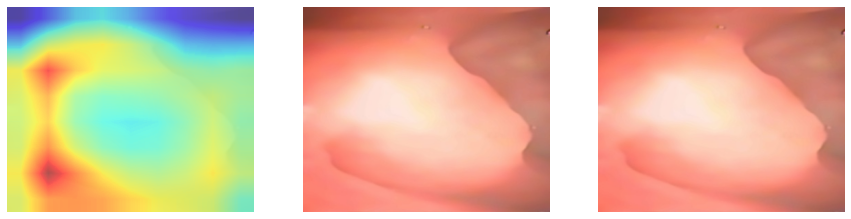

[[0.6691286 0.3308714]]


In [ ]:
img_name = '3754852_0705110712_I00053203321.jpg'

img_path = "/content/drive/My Drive/Colab Notebooks/聖馬爾定/Dataset_Check/Original/1/" + img_name
orig_path = "/content/drive/My Drive/Colab Notebooks/聖馬爾定/Dataset_Check/Original/1/" + img_name
# img_path = "/content/roi.jpg"
orig = cv2.imread(img_path)

#orig2 = cv2.imread(orig_path)
#orig2 = cv2.resize(orig2, (orig.shape[0],orig.shape[1]))  #(width, height)

image = preprocess_img(img_path, image_size)
orig = np.expand_dims(orig, axis=0)

last_conv_layer_name = "conv_7b_ac"
classifier_layer_names = ["flatten"]

heatmap = make_gradcam_heatmap(
    image, model, last_conv_layer_name, classifier_layer_names
)

plot_heatmap(heatmap, img_path, orig_path)

predict_datagen = ImageDataGenerator(rescale=1./255)

predict_generator = predict_datagen.flow(image,
                                         y=None,
                                         batch_size=1)

preds = model.predict(predict_generator)
i = np.argmax(preds, axis=-1).astype('str')
print(preds)

# Arg_Adjust

In [ ]:
range = [0.8, 1.0, 1.2, 1.4, 1.6 , 1.8, 2.0]

In [ ]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []

test_accuracy = []
test_precision = []
test_recall = []
test_f1 = []

for i in range:
  train_datagen = ImageDataGenerator(rotation_range=15, 
                                     rescale=1./255, 
                                     shear_range=0.1, 
                                     zoom_range=0.2,
                                     brightness_range=[i,i],
                                     horizontal_flip=True, 
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     validation_split=0.15)
  
  train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    '/content/drive/My Drive/Colab Notebooks/聖馬爾定/Dataset_Check/Original/', 
                                                    x_col='path', 
                                                    y_col='label', 
                                                    target_size=image_size, 
                                                    class_mode='categorical', 
                                                    batch_size=BS, 
                                                    subset='training')
  
  validation_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    '/content/drive/My Drive/Colab Notebooks/聖馬爾定/Dataset_Check/Original/', 
                                                    x_col='path', 
                                                    y_col='label', 
                                                    target_size=image_size, 
                                                    class_mode='categorical', 
                                                    batch_size=BS,
                                                    subset='validation')

  test_gen = ImageDataGenerator(brightness_range=[i,i],
                                rescale=1./255)

  test_generator = test_gen.flow_from_dataframe(
      test_df, 
      '/content/drive/My Drive/Colab Notebooks/聖馬爾定/Dataset_Check/Original/', 
      x_col='path', 
      y_col=None, 
      class_mode=None, 
      target_size=image_size, 
      batch_size=1,
      shuffle=False
  )

  train_inTest_generator = test_gen.flow_from_dataframe(
      train_df, 
      '/content/drive/My Drive/Colab Notebooks/聖馬爾定/Dataset_Check/Original/', 
      x_col='path', 
      y_col=None, 
      class_mode=None, 
      target_size=image_size, 
      batch_size=1,
      shuffle=False
  )

  model = create_new_model()

  learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                             patience=7, 
                                             factor=0.5, 
                                             min_lr=0.00001)
  
  callbacks = [learning_rate_reduction]
  
  
  H = model.fit(
      train_generator,
      epochs=150,
      validation_data= validation_generator,
      callbacks=callbacks
      )

  predict = model.predict(test_generator)
  test_predict = np.argmax(predict, axis=-1).astype('str')
  test_df['predict'] = test_predict

  y_test = test_df['label'].astype('int32').values
  pre_y = test_df['predict'].astype('int32').values

  test_accuracy.append(accuracy_score(y_test, pre_y))
  test_precision.append(precision_score(y_test, pre_y))
  test_recall.append(recall_score(y_test, pre_y))
  test_f1.append(f1_score(y_test, pre_y))

  predict = model.predict(train_inTest_generator)
  test_predict = np.argmax(predict, axis=-1).astype('str')
  train_df['predict'] = test_predict

  y_test = train_df['label'].astype('int32').values
  pre_y = train_df['predict'].astype('int32').values

  train_accuracy.append(accuracy_score(y_test, pre_y))
  train_precision.append(precision_score(y_test, pre_y))
  train_recall.append(recall_score(y_test, pre_y))
  train_f1.append(f1_score(y_test, pre_y))

Found 119 validated image filenames belonging to 2 classes.
Found 21 validated image filenames belonging to 2 classes.
Found 25 validated image filenames.
Found 140 validated image filenames.
219062272/219055592 [==============================] - 3s 0us/step
Epoch 1/150
4/4 [==============================] - 46s 11s/step - loss: 0.9509 - accuracy: 0.6134 - val_loss: 0.6098 - val_accuracy: 0.6667
Epoch 2/150
4/4 [==============================] - 3s 870ms/step - loss: 0.6808 - accuracy: 0.6303 - val_loss: 0.5430 - val_accuracy: 0.7143
Epoch 3/150
4/4 [==============================] - 3s 870ms/step - loss: 0.5856 - accuracy: 0.6975 - val_loss: 0.5174 - val_accuracy: 0.6667
Epoch 4/150
4/4 [==============================] - 4s 878ms/step - loss: 0.4994 - accuracy: 0.7143 - val_loss: 0.5930 - val_accuracy: 0.6667
Epoch 5/150
4/4 [==============================] - 4s 882ms/step - loss: 0.4625 - accuracy: 0.7479 - val_loss: 0.5108 - val_accuracy: 0.7143
Epoch 6/150
4/4 [====================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Found 119 validated image filenames belonging to 2 classes.
Found 21 validated image filenames belonging to 2 classes.
Found 25 validated image filenames.
Found 140 validated image filenames.
Epoch 1/150
4/4 [==============================] - 6s 2s/step - loss: 1.1528 - accuracy: 0.5882 - val_loss: 0.5158 - val_accuracy: 0.7619
Epoch 2/150
4/4 [==============================] - 4s 886ms/step - loss: 0.7677 - accuracy: 0.6975 - val_loss: 0.9081 - val_accuracy: 0.5238
Epoch 3/150
4/4 [==============================] - 3s 827ms/step - loss: 0.6570 - accuracy: 0.7227 - val_loss: 0.5499 - val_accuracy: 0.6190
Epoch 4/150
4/4 [==============================] - 3s 817ms/step - loss: 0.5735 - accuracy: 0.6807 - val_loss: 0.5415 - val_accuracy: 0.7619
Epoch 5/150
4/4 [==============================] - 3s 818ms/step - loss: 0.5369 - accuracy: 0.7311 - val_loss: 0.4610 - val_accuracy: 0.7619
Epoch 6/150
4/4 [==============================] - 3s 823ms/step - loss: 0.5163 - accuracy: 0.7563 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Found 119 validated image filenames belonging to 2 classes.
Found 21 validated image filenames belonging to 2 classes.
Found 25 validated image filenames.
Found 140 validated image filenames.
Epoch 1/150
4/4 [==============================] - 6s 2s/step - loss: 1.4606 - accuracy: 0.5882 - val_loss: 0.9753 - val_accuracy: 0.5238
Epoch 2/150
4/4 [==============================] - 3s 829ms/step - loss: 0.7416 - accuracy: 0.6723 - val_loss: 0.6786 - val_accuracy: 0.4762
Epoch 3/150
4/4 [==============================] - 3s 822ms/step - loss: 0.6616 - accuracy: 0.6555 - val_loss: 0.6443 - val_accuracy: 0.5238
Epoch 4/150
4/4 [==============================] - 3s 812ms/step - loss: 0.6139 - accuracy: 0.6723 - val_loss: 0.6747 - val_accuracy: 0.5238
Epoch 5/150
4/4 [==============================] - 4s 896ms/step - loss: 0.5899 - accuracy: 0.6807 - val_loss: 0.7253 - val_accuracy: 0.5238
Epoch 6/150
4/4 [==============================] - 3s 811ms/step - loss: 0.5825 - accuracy: 0.6807 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Found 119 validated image filenames belonging to 2 classes.
Found 21 validated image filenames belonging to 2 classes.
Found 25 validated image filenames.
Found 140 validated image filenames.
Epoch 1/150
4/4 [==============================] - 6s 2s/step - loss: 1.5359 - accuracy: 0.5966 - val_loss: 0.9433 - val_accuracy: 0.5238
Epoch 2/150
4/4 [==============================] - 3s 830ms/step - loss: 0.7998 - accuracy: 0.5630 - val_loss: 0.6606 - val_accuracy: 0.7143
Epoch 3/150
4/4 [==============================] - 3s 819ms/step - loss: 0.6507 - accuracy: 0.5630 - val_loss: 0.7077 - val_accuracy: 0.5238
Epoch 4/150
4/4 [==============================] - 3s 812ms/step - loss: 0.7839 - accuracy: 0.6218 - val_loss: 0.6436 - val_accuracy: 0.5238
Epoch 5/150
4/4 [==============================] - 3s 818ms/step - loss: 0.6195 - accuracy: 0.6807 - val_loss: 0.5823 - val_accuracy: 0.7619
Epoch 6/150
4/4 [==============================] - 3s 811ms/step - loss: 0.6415 - accuracy: 0.6387 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
test_performance = pd.DataFrame(test_accuracy, columns=['Accuracy'])
test_performance['Precision'] = test_precision
test_performance['Recall'] = test_recall
test_performance['F1'] = test_f1

test_performance.to_csv('/content/drive/My Drive/Colab Notebooks/聖馬爾定/csv/test_performance_sigModel.csv', index=0)

train_performance = pd.DataFrame(train_accuracy, columns=['Accuracy'])
train_performance['Precision'] = train_precision
train_performance['Recall'] = train_recall
train_performance['F1'] = train_f1

train_performance.to_csv('/content/drive/My Drive/Colab Notebooks/聖馬爾定/csv/train_performance_sigModel.csv', index=0)

In [ ]:
test_performance

,Accuracy,Precision,Recall,F1
0,0.84,1.000000,0.6,0.750000
1,0.92,1.000000,0.8,0.888889
2,0.80,0.857143,0.6,0.705882
3,0.84,0.800000,0.8,0.800000


In [ ]:
train_performance

,Accuracy,Precision,Recall,F1
0,0.964286,0.977778,0.916667,0.946237
1,0.971429,0.958333,0.958333,0.958333
2,0.857143,0.911765,0.645833,0.756098
3,0.907143,0.926829,0.791667,0.853933


In [ ]:
def count_diffs(a, b, to_max_1, to_max_2):
    n_better = 0
    n_worse = 0

    for f in to_max_1:
      n_better += a[f] > b[f]
      n_worse += a[f] < b[f]

    for f in to_max_2:
        n_better += a[f] > b[f]
        n_worse += a[f] < b[f]

    return n_better, n_worse


def find_skyline_bnl(df, to_max_1, to_max_2):
    """Finds the skyline using a block-nested loop."""

    rows = df.to_dict(orient='index')

    # Use the first row to initialize the skyline
    skyline = {df.index[0]}

    # Loop through the rest of the rows
    for i in df.index[1:]:

        to_drop = set()
        is_dominated = False

        for j in skyline:

            n_better, n_worse = count_diffs(rows[i], rows[j], to_max_1, to_max_2)

            # Case 1
            if n_worse > 0 and n_better == 0:
                is_dominated = True
                break

            # Case 3
            if n_better > 0 and n_worse == 0:
                to_drop.add(j)

        if is_dominated:
            continue

        skyline = skyline.difference(to_drop)
        skyline.add(i)

    return pd.Series(df.index.isin(skyline), index=df.index)

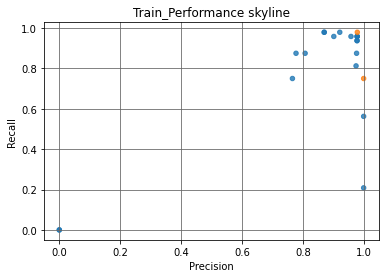

In [ ]:
skyline = find_skyline_bnl(df=train_performance, to_max_1=['Recall'], to_max_2=['Precision'])
colors = skyline.map({True: 'C1', False: 'C0'})
ax = train_performance.plot.scatter(x='Precision', y='Recall', c=colors, alpha=0.8)
ax.set_title('Train_Performance skyline')
plt.grid(b=True, which='major', color='#666666', linestyle='-')

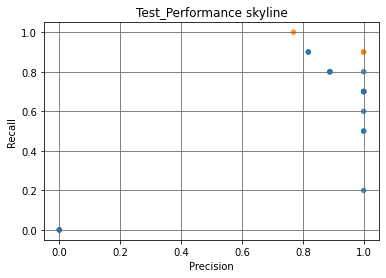

In [ ]:
skyline = find_skyline_bnl(df=test_performance, to_max_1=['Recall'], to_max_2=['Precision'])
colors = skyline.map({True: 'C1', False: 'C0'})
ax = test_performance.plot.scatter(x='Precision', y='Recall', c=colors, alpha=0.8)
ax.set_title('Test_Performance skyline')
plt.grid(b=True, which='major', color='#666666', linestyle='-')

# Test

(300, 360, 3)


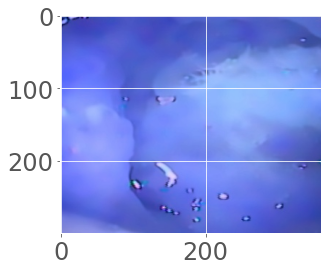

In [ ]:
path = ["roi.jpg"]
predict_df = pd.DataFrame(path, columns=['path'])

predict_datagen = ImageDataGenerator(rescale=1./255)
predict_generator = predict_datagen.
# _from_dataframe(predict_df,
#                                                         '/content/drive/My Drive/Colab/Dataset/Test', 
#                                                         x_col='path', 
#                                                         y_col=None, 
#                                                         class_mode=None, 
#                                                         target_size=(300, 360), 
#                                                         batch_size=1,
#                                                         shuffle=False
#                                                         )

preds = model.predict(predict_generator)
i = np.argmax(preds, axis=-1).astype('str')
print(i)

In [ ]:
img_name = '3754852_0705110712_I00053203321.jpg'

img_path = "/content/drive/My Drive/Colab Notebooks/聖馬爾定/Dataset_Check/Original/1/" + img_name
orig_path = "/content/drive/My Drive/Colab Notebooks/聖馬爾定/Dataset_Check/Original/1/" + img_name
# img_path = "/content/roi.jpg"
orig = cv2.imread(img_path)
orig.shape[0]

300